# Импорты

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

In [38]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [39]:
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Данные

In [40]:
scab = pd.read_csv('skab_valve_1.csv', sep=';', index_col=['datetime'], parse_dates=['datetime'])
scab.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:34:37,0.028030,0.040400,1.18285,0.054711,69.9219,24.9122,229.918,32.9875,0.0,0.0
2020-03-09 12:34:38,0.026952,0.038880,1.45268,-0.273216,69.9147,24.9038,219.566,32.0129,0.0,0.0
2020-03-09 12:34:39,0.027958,0.040660,1.02300,0.054711,69.8861,24.9055,237.717,32.9875,0.0,0.0
2020-03-09 12:34:40,0.027277,0.040736,1.22751,-0.273216,69.8397,24.9110,227.621,32.0000,0.0,0.0
2020-03-09 12:34:41,0.027210,0.039489,1.21526,-0.273216,69.9136,24.9110,221.634,32.0129,0.0,0.0


In [41]:
tcouple = pd.DataFrame({'Thermocouple': scab.Thermocouple}) # для удобства
tcouple.head()

,Thermocouple
datetime,
2020-03-09 12:34:37,24.9122
2020-03-09 12:34:38,24.9038
2020-03-09 12:34:39,24.9055
2020-03-09 12:34:40,24.9110
2020-03-09 12:34:41,24.9110


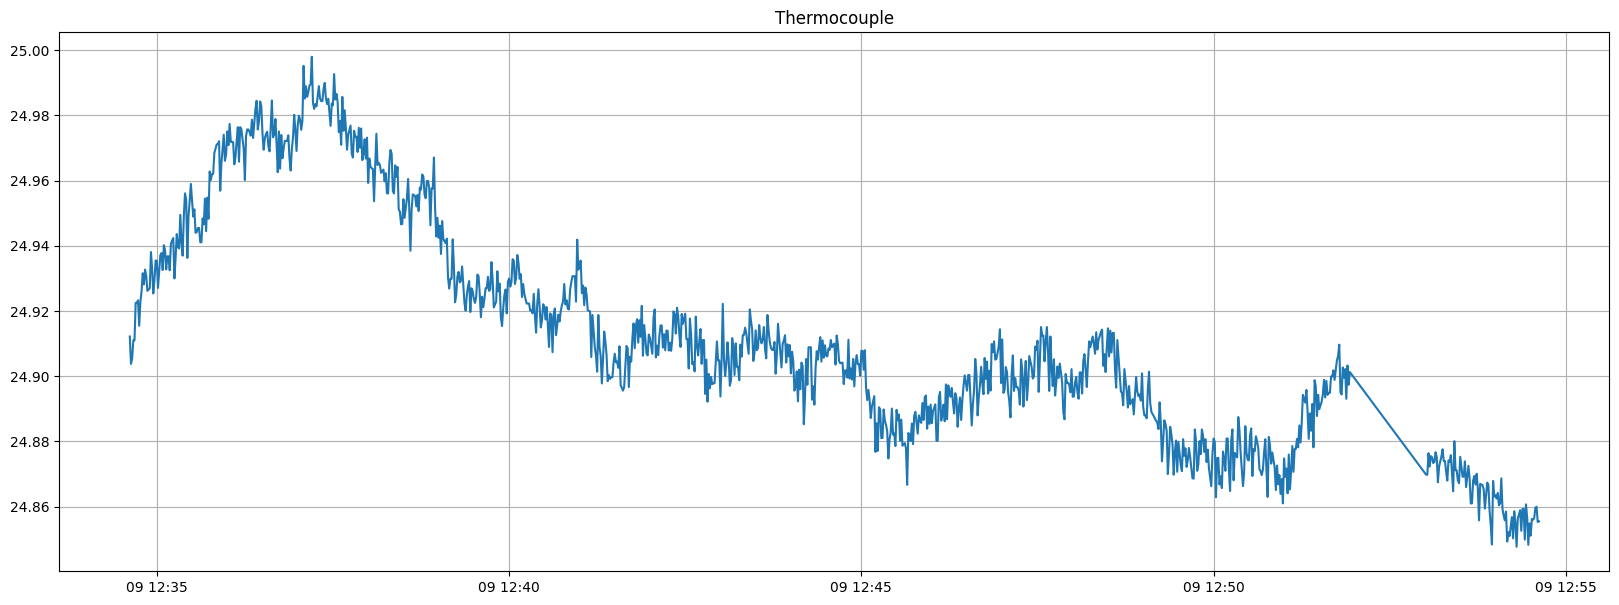

In [42]:
plt.figure(figsize=(20, 7))
plt.plot(tcouple.Thermocouple)
plt.title('Thermocouple')
plt.grid(True)
plt.show()

Временной ряд имеет тренд (на убывание).

Ряд не стационарен и отсутствует сезонность.

Выбирем метрику MAE для дальнеших замеров качества.

In [43]:
# деление на тренировочный и тестовый
def timeseries_train_test_split(df, test_size):

    test_index = int(len(df)*(1-test_size))

    df_train = df.iloc[:test_index]
    df_test = df.iloc[test_index:]

    return df_train, df_test

In [44]:
df_train, df_test = timeseries_train_test_split(tcouple, test_size=0.3)
df_test.head()

,Thermocouple
datetime,
2020-03-09 12:47:52,24.8890
2020-03-09 12:47:53,24.8868
2020-03-09 12:47:54,24.9007
2020-03-09 12:47:55,24.8980
2020-03-09 12:47:56,24.8980


# Прогнозирование

## Бейзлайн

In [45]:
# скользящее среднее
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(tcouple, 30)

24.85524333333333

In [72]:
# визуализация и вычисление выбранной метрики
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Скользящее среднее\n Размер окна = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    mae = None

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        print(f'MAE: {mae}')
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

    return mae

MAE: 0.00668322994987469


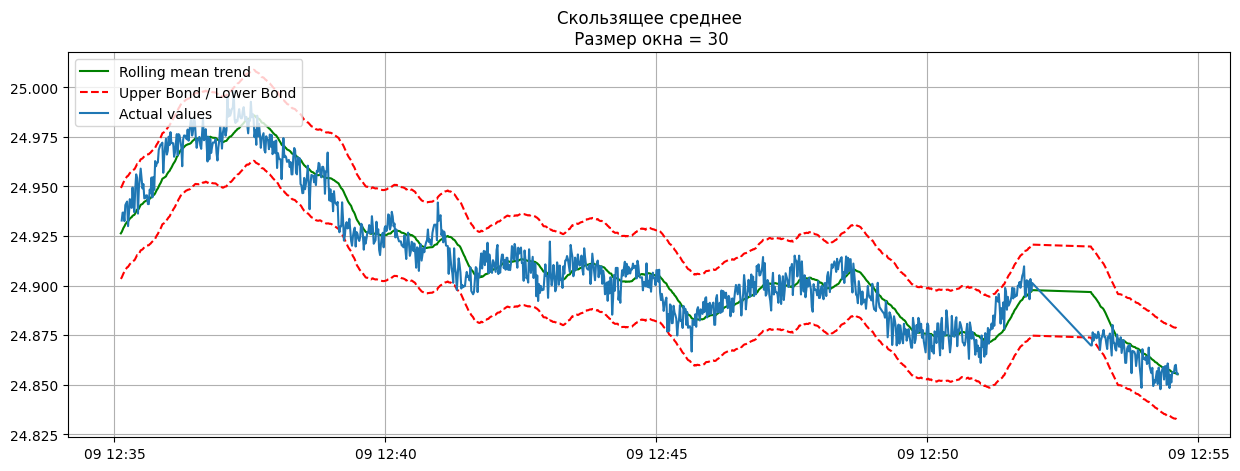

In [75]:
mae1 = plotMovingAverage(tcouple, 30, plot_intervals = True)

MAE: 0.008993596067053617


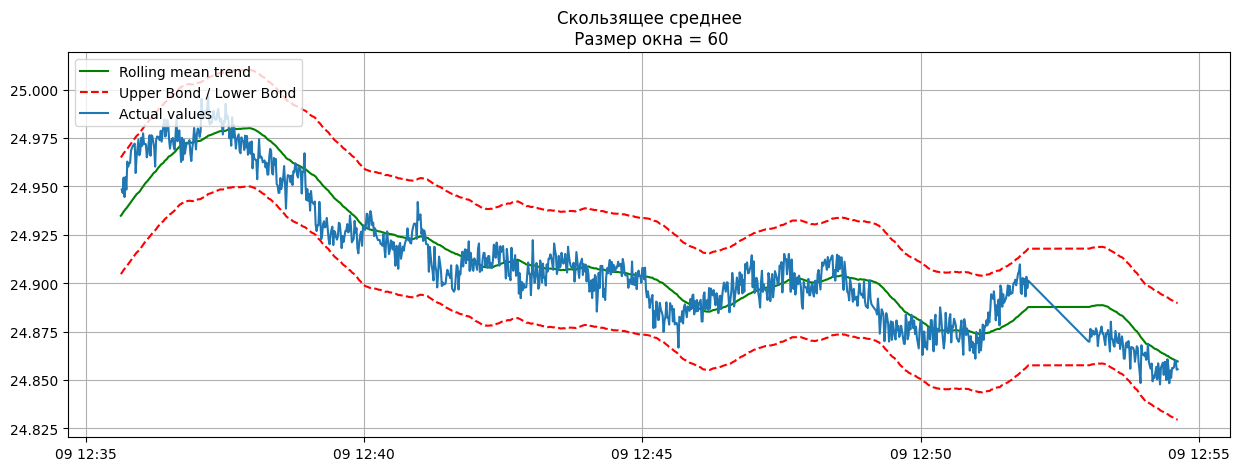

In [70]:
plotMovingAverage(tcouple, 60, plot_intervals = True) # возьмем окно в 60 секунд

## Статистическая модель

In [52]:
#Тест Дики-Фуллера и построние графиков ACF/PACF
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


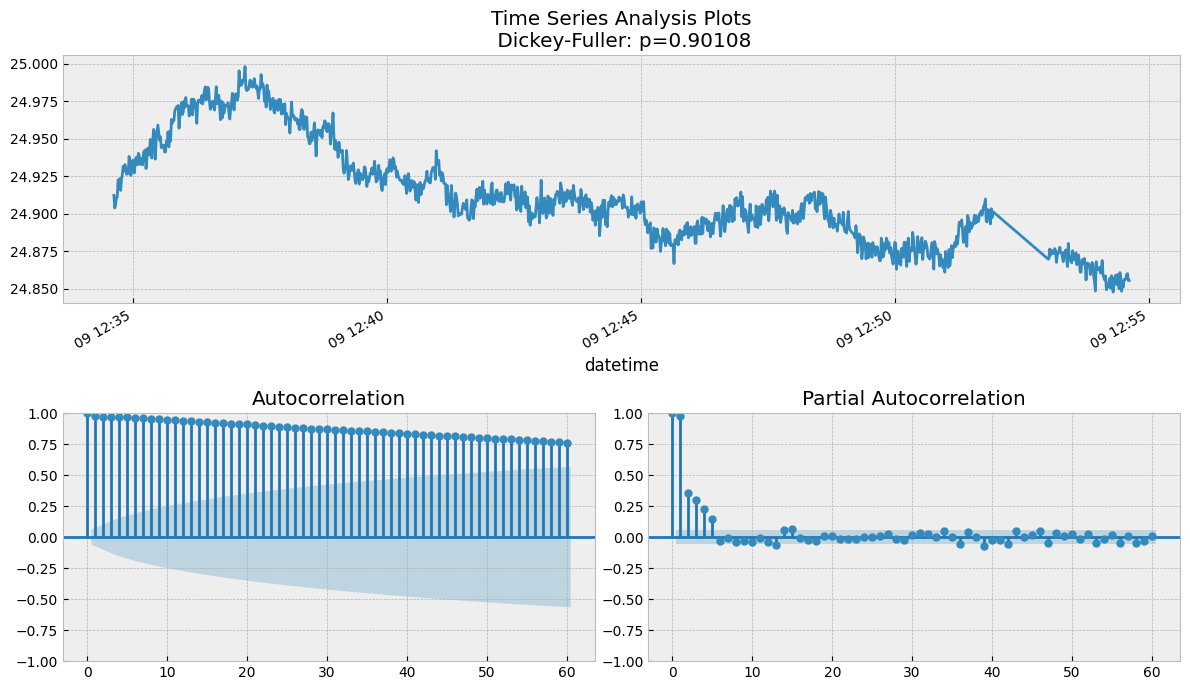

In [53]:
tsplot(tcouple.Thermocouple, lags=60)

Тест Дики-Фуллера показывает, что у ряда отсутствует сезонность и он не стационарен, как было и первоначально.

Приведем его к стационарности с помощью дифференцирования и еще раз проверим с помощью теста Дики-Фуллера и графиков ACF/PACF.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


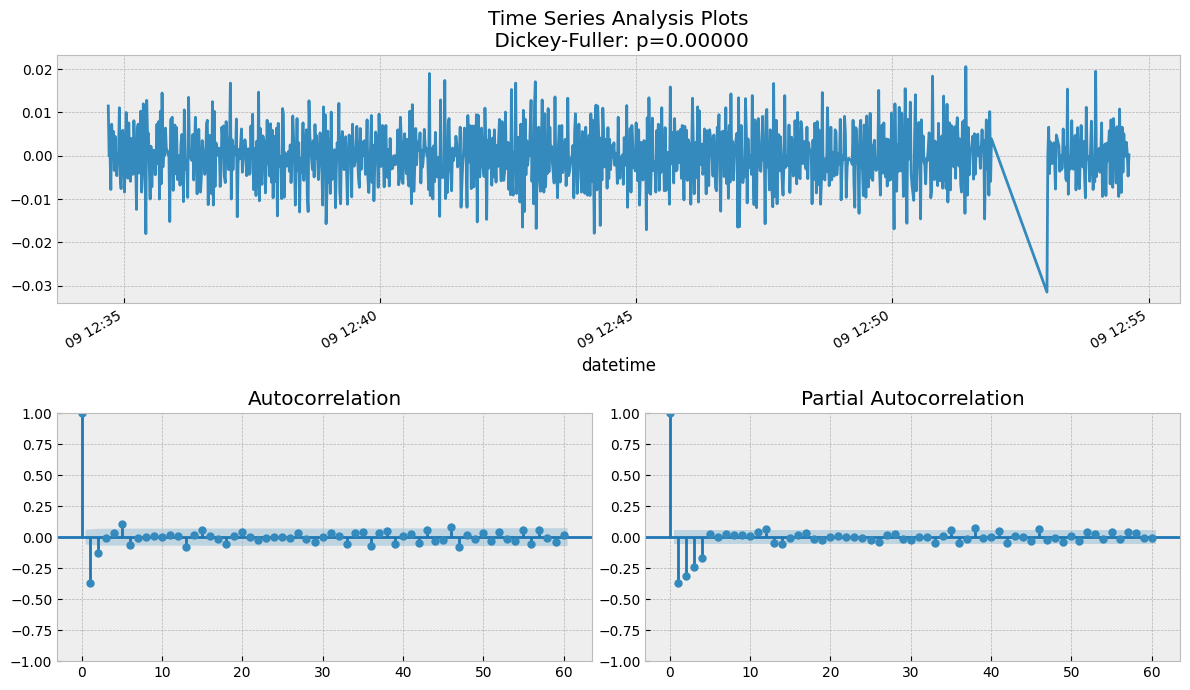

In [54]:
diff = tcouple.Thermocouple - tcouple.Thermocouple.shift(1)
tsplot(diff[5:], lags=60)

Ряд стал стационарным, но все также не сезонный. Поэтому выберем для обучения модель ARIMA для прогнозирования значений ряда.

In [55]:
# параметры
p = range(2,5)
d = range(0,2)
q = range(2,5)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf

In [56]:
import warnings
warnings.filterwarnings("ignore")

results = []

# модель
for params in tqdm_notebook(pdq, desc="Fitting ARIMA models"):
    try:
        model = ARIMA(tcouple.Thermocouple, order=params)
        result = model.fit()

        results.append((params, result.aic))  # сохраняем результаты

        # обновляем лучшие параметры
        if result.aic < best_aic:
            best_pdq = params
            best_aic = result.aic
    # обработка ошибок
    except Exception as e:
        print(f"Error fitting model with parameters {params}: {e}")

print(f"Best parameters: {best_pdq}, AIC: {best_aic}")

# DataFrame для результатов
results_df = pd.DataFrame(results, columns=['parameters', 'aic'])
# сортировка
results_df = results_df.sort_values(by='aic').reset_index(drop=True)

Fitting ARIMA models:   0%|          | 0/18 [00:00<?, ?it/s]

Best parameters: (4, 1, 2), AIC: -8200.669937555598


In [57]:
# Выводим таблицу с результатами
results_df.head()

,parameters,aic
0,"(4, 1, 2)",-8200.669938
1,"(4, 1, 3)",-8199.000024
2,"(4, 1, 4)",-8197.291050
3,"(3, 1, 2)",-8195.835065
4,"(4, 0, 3)",-8194.796844


In [58]:
best_model = ARIMA(tcouple.Thermocouple, order=best_pdq).fit()# Обучение лучшей модели
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:           Thermocouple   No. Observations:                 1094
Model:                 ARIMA(4, 1, 2)   Log Likelihood                4107.335
Date:                Mon, 28 Oct 2024   AIC                          -8200.670
Time:                        12:31:35   BIC                          -8165.693
Sample:                             0   HQIC                         -8187.434
                               - 1094                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7653      0.248     -3.080      0.002      -1.252      -0.278
ar.L2         -0.5773      0.121     -4.765      0.000      -0.815      -0.340
ar.L3         -0.3969      0.083     -4.786      0.0

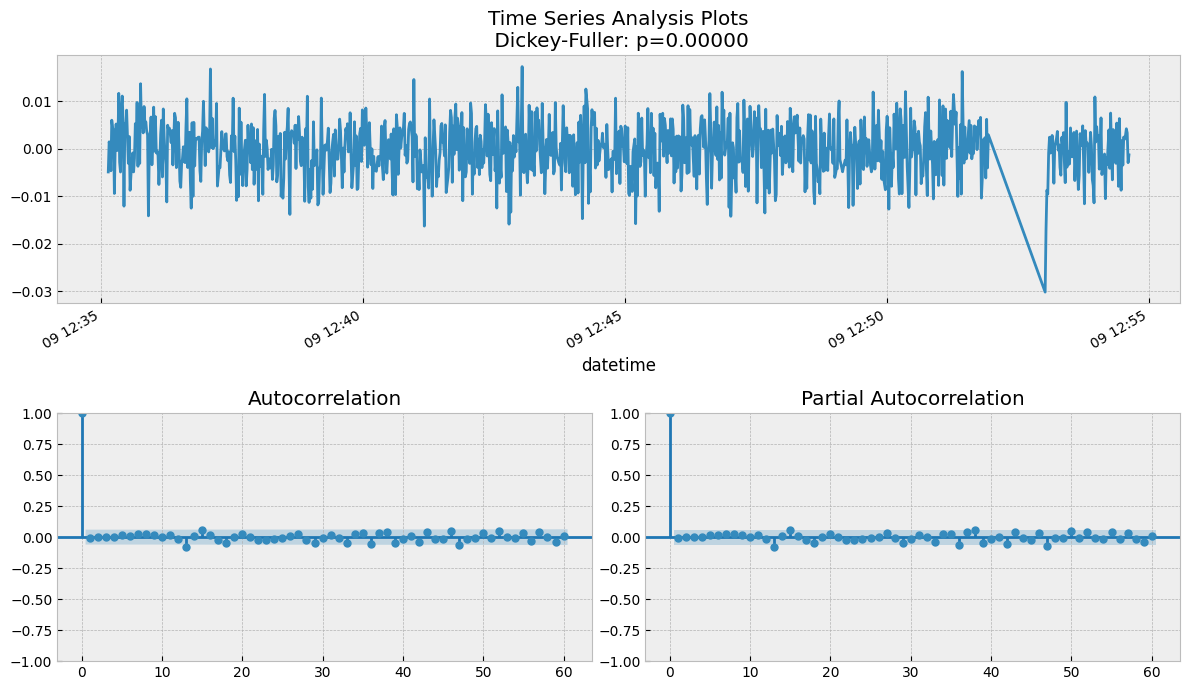

In [59]:
# Визуализация результатов работы модели
tsplot(best_model.resid[30:], lags=60)

In [76]:
def calculateMAE(series, model, d):
    data = series.copy()
    data.columns = ['actual']
    # добавление предсказанных значений от модели
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:d] = np.NaN
    # расчет MAE на основе значений модели и фактических
    mae = mean_absolute_error(data['actual'][d:], data['arima_model'][d:])

    return mae

mae2 = calculateMAE(tcouple, best_model, 1)
print(f'Mean Absolute Error: {mae2:.4f}')

Mean Absolute Error: 0.0045


## Классическая модель

In [61]:
# лаги
df = pd.DataFrame(tcouple.Thermocouple.copy())
df.columns = ["y"]

for i in range(1, 11):
    df["lag_{}".format(i)] = df.y.shift(i)

In [62]:
# признаки времени
df['second'] = df.index.second
df['minute'] = df.index.minute

In [63]:
df.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,second,minute
datetime,,,,,,,,,,,,,
2020-03-09 12:54:33,24.8565,24.8560,24.8562,24.8511,24.8549,24.8483,24.8568,24.8607,24.8499,24.8593,24.8593,33,54
2020-03-09 12:54:34,24.8596,24.8565,24.8560,24.8562,24.8511,24.8549,24.8483,24.8568,24.8607,24.8499,24.8593,34,54
2020-03-09 12:54:35,24.8600,24.8596,24.8565,24.8560,24.8562,24.8511,24.8549,24.8483,24.8568,24.8607,24.8499,35,54
2020-03-09 12:54:36,24.8553,24.8600,24.8596,24.8565,24.8560,24.8562,24.8511,24.8549,24.8483,24.8568,24.8607,36,54
2020-03-09 12:54:37,24.8555,24.8553,24.8600,24.8596,24.8565,24.8560,24.8562,24.8511,24.8549,24.8483,24.8568,37,54


Обучим модель случайного леса

In [64]:
# разделение на тестовую и тренировочную выборки
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

y = df.dropna().y
X = df.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [65]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=6, random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

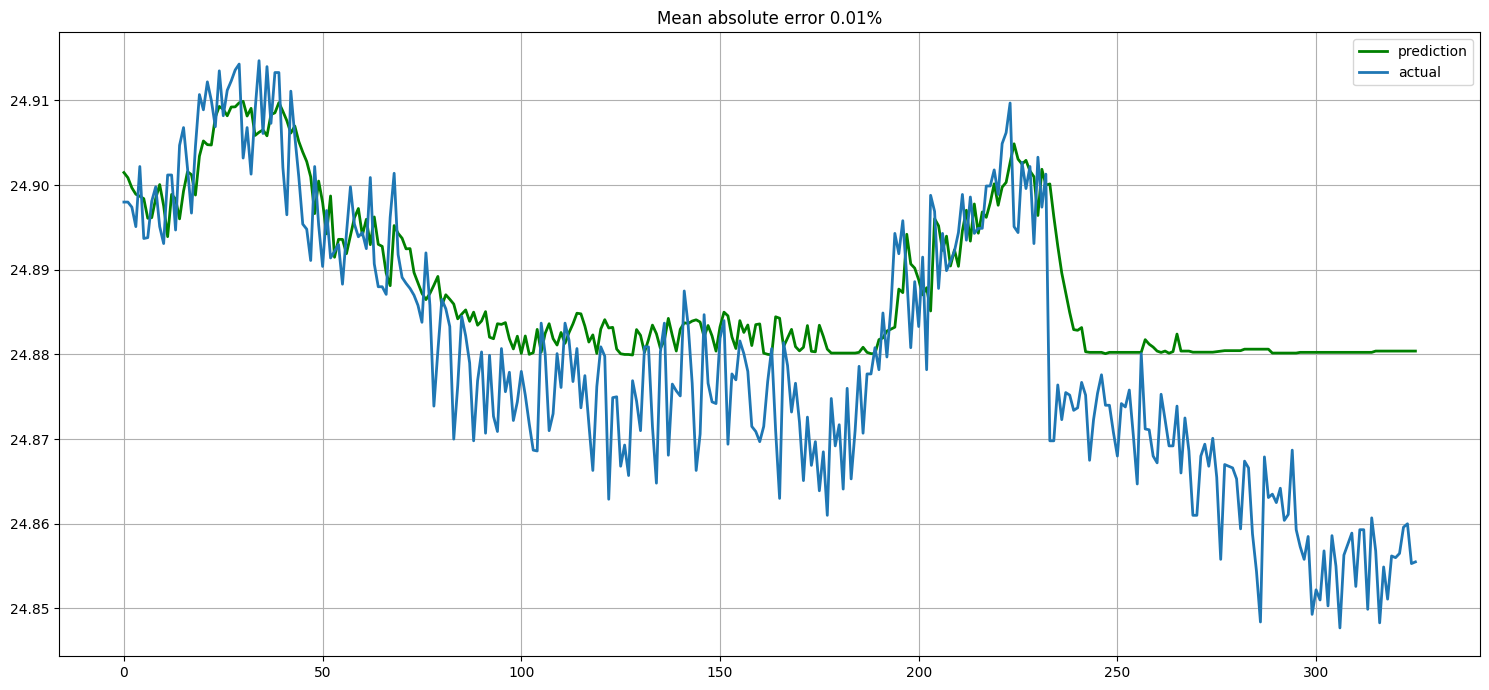

In [67]:
# Визуализация и подсчет метрики
def plotModelResults(model, X_train=X_train, X_test=X_test):

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    error = mean_absolute_error(prediction, y_test)
    plt.title("Mean absolute error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

plotModelResults(forest, X_train=X_train, X_test=X_test)

## Нейросетевая модель

In [25]:
%%capture
!pip install etna[all] -U

In [26]:
import torch
import random

import pandas as pd
import numpy as np

from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform, LagTransform, LinearTrendTransform, StandardScalerTransform
from etna.metrics import SMAPE, MAPE, MAE
from etna.analysis import plot_backtest
from etna.models import SeasonalMovingAverageModel
from etna.models.nn import DeepARModel, RNNModel
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

from pytorch_forecasting.data import GroupNormalizer

### RNN

In [27]:
newscab = pd.read_csv('skab_valve_1.csv', sep=';')
newscab.head()

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 12:34:37,0.028030,0.040400,1.18285,0.054711,69.9219,24.9122,229.918,32.9875,0.0,0.0
1,2020-03-09 12:34:38,0.026952,0.038880,1.45268,-0.273216,69.9147,24.9038,219.566,32.0129,0.0,0.0
2,2020-03-09 12:34:39,0.027958,0.040660,1.02300,0.054711,69.8861,24.9055,237.717,32.9875,0.0,0.0
3,2020-03-09 12:34:40,0.027277,0.040736,1.22751,-0.273216,69.8397,24.9110,227.621,32.0000,0.0,0.0
4,2020-03-09 12:34:41,0.027210,0.039489,1.21526,-0.273216,69.9136,24.9110,221.634,32.0129,0.0,0.0


In [28]:
newdf = pd.DataFrame({'timestamp': newscab.datetime,'Thermocouple': newscab.Thermocouple})
newdf

,timestamp,Thermocouple
0,2020-03-09 12:34:37,24.9122
1,2020-03-09 12:34:38,24.9038
2,2020-03-09 12:34:39,24.9055
3,2020-03-09 12:34:40,24.9110
4,2020-03-09 12:34:41,24.9110
...,...,...
1089,2020-03-09 12:54:33,24.8565
1090,2020-03-09 12:54:34,24.8596
1091,2020-03-09 12:54:35,24.8600
1092,2020-03-09 12:54:36,24.8553


In [30]:
newdf['timestamp'] = newdf['timestamp'].str.replace('2020-03-09', '')

In [33]:
newdf

,timestamp,Thermocouple
0,12:34:37,24.9122
1,12:34:38,24.9038
2,12:34:39,24.9055
3,12:34:40,24.9110
4,12:34:41,24.9110
...,...,...
1089,12:54:33,24.8565
1090,12:54:34,24.8596
1091,12:54:35,24.8600
1092,12:54:36,24.8553


In [ ]:
# подготовка данных
newdf['target'] = newdf['Thermocouple']  # Добавляем целевую переменную

In [ ]:
ts = TSDataset(newdf, freq='S') # выдает ошибку об отсутсвии сегмента, поэтому дальше не получается
ts.head()

In [ ]:
HORIZON = 7

model_rnn = RNNModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    input_size=11,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[StandardScalerTransform(in_column="target"), transform_lag],
)

In [ ]:
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

In [ ]:
score = metrics_rnn["SMAPE"].mean()
print(f"SMAPE для LSTM: {score:.3f}")

### DeepAR с Feaure-Engineering

In [ ]:
transform_date = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    out_column='dateflag'
)

num_lags = 10
transform_lag = LagTransform(
    in_column='target',
    lags=[HORIZON + i for i in range(num_lags)],
    out_column='target_lag'
)
lag_columns = [f'target_lag_{HORIZON+i}' for i in range(num_lags)]

In [ ]:
dataset_builder_deepar = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=['time_idx'] + lag_columns,
    time_varying_unknown_reals=['target'],
    time_varying_known_categoricals=['dateflag_day_number_in_week'],
    target_normalizer=GroupNormalizer(groups=['segment']),
)

In [ ]:
model_deepar = DeepARModel(
    dataset_builder=dataset_builder_deepar,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64
)

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date]
)

metrics_deepar, forecast_deepar, _ = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

In [ ]:
score = metrics_deepar['SMAPE'].mean()
print(f"SMAPE для DeepAR с FE: {score:.3f}")

### Визуализация моделей